In [208]:
#libraries
import requests 
from bs4 import BeautifulSoup
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn import impute
import statsmodels.api as sm

## 1. Scraping for information: 

In [209]:

def scrape_aldi_jobs(starting_page = 'head-office'):
    url = "https://www.aldirecruitment.co.uk/" + starting_page
    page = requests.get(url)
    soup = BeautifulSoup(page.content, "html.parser")
    links = []
    for link in soup.findAll('a'):
        new_link = link.get('href')
        if new_link != None and new_link.startswith('/head-office/'):
            new_link = new_link.replace('/head-office','')
            if new_link != '/':
                links.append(new_link)
    # Adding new containter lists
    Pension = []
    hols = []
    department = []
    titles = []
    ubs = []
    lbs = []
    hours = []
    for link in links:
        category_url = url + link
        page = requests.get(category_url)
        soup = BeautifulSoup(page.content, "html.parser")
        postings = soup.findAll("div", class_="c-career--dropdown")
        for posting in postings:
            dep_name = link.replace('-',' ').replace('/','')
            department.append(dep_name)
            titles.append(posting.find("div", class_="c-career--dropdown__content").find('h2').text)
            details = posting.findAll("div", class_="c-job-details__content")

            for detail in details:
                detail_title = detail.find('span', class_="c-job-details__title").text
                detail_text = detail.find('div', class_="c-job-details__text").text
                
                # Collecting the holiday allowance from the html text.
                if detail_title.lower() == 'holiday allowance' or detail_title.lower() == 'holiday' or detail_title.lower() == 'holiday allownance': # There were spelling errors and I had received NaNs because of those errors on a granular level. Hence included the spelling alternatives.
                    for i in range(len(detail_text.split())):
                        if 'weeks’' or 'days’' in detail_text.split():
                            holiday = int(detail_text.split()[0])
                            if holiday>7: # The holiday allowance for some roles were in days instead of weeks so this condition is to detect those and standardise them to weeks. 
                                holiday = holiday/7
                    hols.append(holiday)
                  
                elif detail_title.lower() == 'hours and benefits' or detail_title.lower() == 'benefits':
                    work_time = None
                    for s in detail_text.split():
                        if '-hour' in s:
                            work_time = s
                            if '-hours' in s:
                                work_time = int(work_time.replace('-hours',''))
                            else:
                                work_time = int(work_time.replace('-hour',''))

                    for i in range(len(detail_text.split())): # This iteration is to solve the problem of missing weekly hours. The issue was due to differently constructed text to describe weekly hours. 
                        if detail_text.split()[i] == "hours": # So instead of "x-hour(s)", the loop looks for just "hours" and picks the string before the "hours" and appends.  
                            work_time = int(detail_text.split()[i-1])   
                    hours.append(work_time)

                    # Looking for keywords to capture whether pension offered was from the start or offered later. This is being represented as a Yes/No. 
                    if 'when you start' in detail_text or 'When you start' in detail_text or 'When you join' in detail_text: # After trying and receiving some incorectly labelled observations, I included different forms of strings as keywords. 
                        Pension_from_start = 'Yes'
                    else:
                        Pension_from_start = 'No'  
                    Pension.append(Pension_from_start)

                elif detail_title == 'Salary':
                    temp = detail_text.replace(',','')
                    temp = temp.replace('-','')
                    temp = temp.split()
                    if temp[1].isdigit(): # The HTML text had a space between the salary figure and therefore, the split command was treating it as an extra element. So this condition identifies if there is a digit in the 2nd position of the string list.
                        temp[0] = temp[0] + temp[1] # Here, we concatenate the two string digits. 
                        temp.remove(temp[1]) # Then, we remove the redundant one. 
                    salary_numbers = [float(s[1:]) for s in temp if s.startswith('£')]
                    for salary in salary_numbers:
                        if salary < 6: # Since the text parsed from the salary section had some other smalle digits, here we can identify those unusual smaller digits.
                            salary_numbers.remove(salary) # Remove them from the final list and avoid incorrectly appending lower bound figures.
                else:
                    hols.append(None)
                    
            if len(salary_numbers) > 0:
                        
                if 'per' in temp and 'week' in temp:
                    salary_numbers = [salary*52 for salary in salary_numbers]
                elif 'per' in temp and 'hour' in temp: # Converting hourly figures into annual figures by identifying keywords from the text.
                    salary_numbers = [salary*work_time*52 for salary in salary_numbers]
                ubs.append(max(salary_numbers))
                lbs.append(min(salary_numbers))
            else:
                ubs.append(None)
                lbs.append(None)
                
    # Completing the dataframe with new variables.                
    job_data = pd.DataFrame(
        {'Department': department,
         'Job title': titles,
         'Salary lower': lbs,
         'Salary upper': ubs,       
         'Weekly hours': hours,
         'Holiday weeks': hols,
         'Pension from start': Pension
        })
    return job_data


In [210]:
aldi_job_data = scrape_aldi_jobs()
aldi_job_data.head()
df = aldi_job_data #smaller name to ease the following code. 

## 2. Analysing the dataframe:
### 2.1. Visualising feautures.

array([[<AxesSubplot:title={'center':'Salary lower'}>,
        <AxesSubplot:title={'center':'Salary upper'}>],
       [<AxesSubplot:title={'center':'Weekly hours'}>,
        <AxesSubplot:title={'center':'Holiday weeks'}>]], dtype=object)

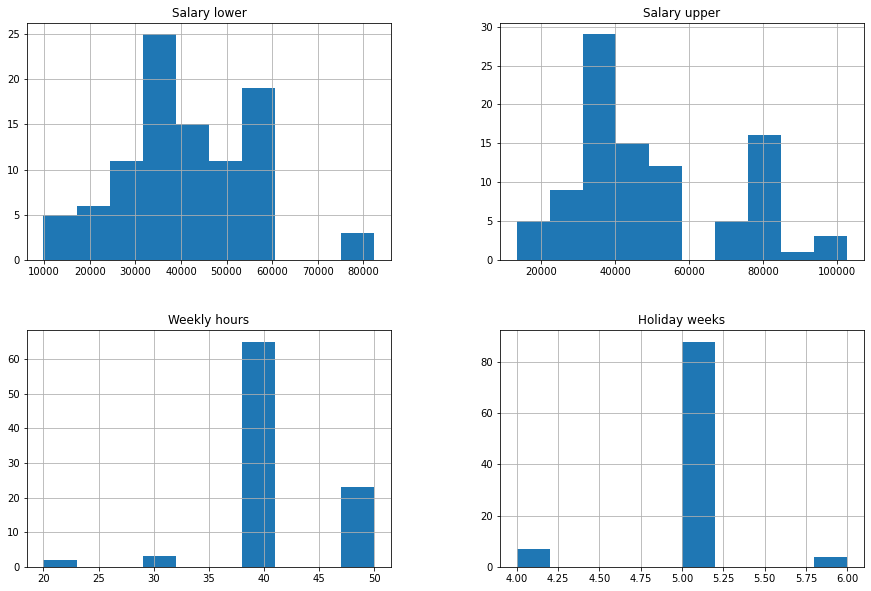

In [211]:
df.hist(figsize=(15,10))

### 2.2. Understanding department-wise differences in mean salaries and weekly hours.

In [212]:
df.groupby(["Department"])['Salary upper'].mean().sort_values()


Department
quality control                 26017.466667
regional administration         34923.857143
quality assurance               45775.000000
national buying                 46238.500000
customer service                47333.520000
supply chain management         48543.125000
merchandising category          49793.750000
national administration         50541.571429
it                              54781.500000
hr                              56675.000000
ecommerce                       57506.666667
corporate responsibility        58247.500000
marketing communications        58247.500000
national property               58716.250000
global business coordination    59163.750000
Name: Salary upper, dtype: float64

In [213]:
df.groupby(["Department"])['Salary lower'].mean().sort_values()


Department
quality control                 23292.200000
regional administration         24973.285714
national buying                 36401.500000
quality assurance               36716.000000
customer service                38134.440000
supply chain management         38688.125000
national administration         39292.000000
national property               39778.750000
merchandising category          39908.750000
it                              42454.125000
corporate responsibility        43180.000000
marketing communications        43180.000000
hr                              44005.000000
ecommerce                       45885.555556
global business coordination    46954.375000
Name: Salary lower, dtype: float64

In [214]:
df.groupby(["Department"])['Weekly hours'].mean().sort_values()


Department
quality control                 29.333333
regional administration         38.571429
national administration         40.769231
it                              41.250000
hr                              41.666667
national buying                 42.000000
quality assurance               42.000000
global business coordination    42.500000
merchandising category          42.500000
supply chain management         42.500000
ecommerce                       42.857143
customer service                44.000000
corporate responsibility        45.000000
marketing communications        45.000000
national property               46.000000
Name: Weekly hours, dtype: float64

## 3. Pre-processing:
### 3.1 Checking for duplicates and NaN values across the df.

In [215]:
dups = df['Job title'].duplicated()
print(dups.any())
df.isna().any(), df.isna().sum(axis=0)

False


(Department            False
 Job title             False
 Salary lower           True
 Salary upper           True
 Weekly hours           True
 Holiday weeks         False
 Pension from start    False
 dtype: bool,
 Department            0
 Job title             0
 Salary lower          4
 Salary upper          4
 Weekly hours          6
 Holiday weeks         0
 Pension from start    0
 dtype: int64)

In [216]:
#Lower Salary, Upper Salary, and Weekly Hours seem to have some observations with NaN
df[df['Salary lower'].isna()] 



,Department,Job title,Salary lower,Salary upper,Weekly hours,Holiday weeks,Pension from start
21,national buying,National Buying Director,NaN,NaN,NaN,6.0,Yes
48,global business coordination,GBC Director,NaN,NaN,NaN,6.0,Yes
77,national property,Regional Property Director,NaN,NaN,50.0,6.0,Yes
90,quality assurance,Quality Assurance Director,NaN,NaN,NaN,6.0,Yes


### 3.2. Treating the NaN values

In [217]:
# We delete these observations because they seem to be senior job roles and without understanding their basic salaries, their competitive analysis has less value. 
df.dropna(subset=['Salary lower', 'Salary upper'], inplace=True)
df[df['Weekly hours'].isna()]

,Department,Job title,Salary lower,Salary upper,Weekly hours,Holiday weeks,Pension from start
6,national administration,National Administration Analyst,41200.0,45225.0,NaN,5.0,No
43,ecommerce,eCommerce Analyst,47100.0,54255.0,NaN,5.0,No
44,ecommerce,eCommerce Associate Analyst,41200.0,45225.0,NaN,5.0,No


In [218]:
# We impute the weekly hour NaN values because the information across other variables is consistent. Also, by using the nearest neighour approach, we can estimate weekly hours based on other observations with similar salaries and aviod deleting too many rows. 
imp = impute.KNNImputer(missing_values = np.NaN)
df_tofit = df[['Salary lower', 'Salary upper', 'Weekly hours']] # the variables to take into consideration for calculating k-nearest neighbours
imp.fit(df_tofit) # fit the imputer on those set of variables
imp.transform(df_tofit) 
col_tofit = imp.transform(df_tofit)[:,2:] # Now perform the imputation on the specific column/feature
df['Weekly hours'] = col_tofit # equate the imputed column back to the actual dataset column to update the values
df.isna().sum()

Department            0
Job title             0
Salary lower          0
Salary upper          0
Weekly hours          0
Holiday weeks         0
Pension from start    0
dtype: int64

In [219]:
# Rounding off the few awkward numerical values. 
df['Salary lower'] = np.round(df['Salary lower'])
df['Salary upper'] = np.round(df['Salary upper'])

## 4. Adding new features for competitive intelligence:
### 4.1. Growth potential: The percentage increase from lower bound to upper bound for showing how much monetary growth the job role may offer.
### 4.2. H2S: The Hour to Salary ratio to understand the trade-off between hours worked and salary earnt. Lower hours and higher salary (or a ratio closer to zero) will imply a good role. 

In [220]:
df['Growth potential'] = np.round(((df['Salary upper'] - df['Salary lower']) / df['Salary upper']) * 100)
df['H2S'] =  52
df['H2S'] = np.round(((df['H2S'] - df['Holiday weeks']) * df['Weekly hours']) / df['Salary lower'], decimals = 3)
df.describe()

,Salary lower,Salary upper,Weekly hours,Holiday weeks,Growth potential,H2S
count,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000
mean,39224.084211,50342.905263,41.557895,4.926316,20.452632,0.056316
std,14314.636459,20820.633081,5.680717,0.262642,9.859404,0.021497
min,9828.000000,13291.000000,20.000000,4.000000,8.000000,0.029000
25%,32075.000000,37455.000000,40.000000,5.000000,14.000000,0.043000
50%,41200.000000,45225.000000,40.000000,5.000000,17.000000,0.053000
75%,47100.000000,70415.000000,40.000000,5.000000,31.000000,0.059000
max,82415.000000,102875.000000,50.000000,5.000000,52.000000,0.147000


## 5. Hypothesis Testing: salary upper and holiday weeks can explain weekly hours. 
The null hypothesis is that Salary upper and Holiday weeks have no impact on Weekly hours and that their coefficients are zero.
Ho: Beta1 = Beta2 = 0



In [221]:
# Runnning Linear Regression
X = df[['Salary upper', 'Holiday weeks']]
Y = df['Weekly hours']
X = sm.add_constant(X)
lm = sm.OLS(Y, X).fit()
print(lm.summary())

# The output shows that the constant coefficient (Beta0) is quite high and statistically significant. Beta1 is although small, it surely has a high t-value and small p-value. Whereas, Beta2 is larger and has and a good t-score along with a low p-value.
# The adjusted R-squared also seems promising. 
# Based on this statistical evidence, we can reject the null hypothesis and accept that Salary upper and Holiday weeks explain the variation in Weekly hours

                            OLS Regression Results                            
Dep. Variable:           Weekly hours   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.730
Method:                 Least Squares   F-statistic:                     128.3
Date:                Thu, 04 Nov 2021   Prob (F-statistic):           2.44e-27
Time:                        01:41:23   Log-Likelihood:                -236.04
No. Observations:                  95   AIC:                             478.1
Df Residuals:                      92   BIC:                             485.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.1366      5.984      0.190

In [222]:
df.to_csv('Aldi_postings_2021-11-03.csv', index=False)

/Users/agamchug/Desktop
